
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IPMUCD3/a3net_2025/blob/generative_solutions/Lecture_Day3_CuestaLazaro/generative.ipynb)

In [ ]:
!pip install torch torchvision matplotlib tqdm numpy scikit-learn diffusers


# 🎨 Generation: Flow Matching

We're going to learn a flow model that gradually bridges two distribution: a simple Gaussian and our dataset of galaxy images. To start, we will work with a simpler 2D example, the two moon problem, and later adapt it to generate galaxy images. 

Let's break down the key equations that we will use:

1. **The Flow Equation**:
   At the heart of Flow Matching is this equation:

   $\frac{dx_t}{dt} = v_\theta(x_t, t)$

   Where:
   - $x_t$ is our image as it's being transformed
   - $t$ is time (between 0 and 1), at t=0 $p(x_0)$ is $N(0,1)$, at t=1, $p(x_1)$ is the target distribution we wish to sample from.
   - $v_\theta$ is a velocity field we'll parametrise with a neural network, and that will determine the direction in which we need to move to sample from the target distribution. 

2. **The Path** (Linear interpolation from noise to data)

   We chose an interpolant, $x_t$, that obeys:

   $x_t = (1-t)x_0 + tx_1$

   Where:
   - $x_0$ is random noise (our starting point)
   - $x_1$ is a real galaxy image (our target) 

3. **Loss Function**:
   We train our model to minimize:

   $L = \mathbb{E}_{t,x_0,x_1} \left[ \left\| v_\theta(x_t, t) - u(x_0,x_1,t) \right\|^2 \right]$

   Where, given the linear interpolant, the true velocity field is $u(x_0, x_1,t) = x_1 - x_0$. This teaches our model to predict the right direction of change at each step.


Once trained, we can use the learned velocity field to generate new galaxy-like images by:
1. Starting with random noise
2. Solving the ODE to transform the noise into a sample of the data distribution. 

Let's start with the simple 2D problem of two moons. Here is how to generate some sample data that follows the two moon distribution, the label y determines to what moon the point belongs to. 

## Starting Simple: The Two Moons Dataset 🌙🌙

Before tackling galaxy images, let's build intuition with a simple 2D dataset where we can actually *see* what's happening.

The "two moons" dataset creates two curved clusters that look like crescents.

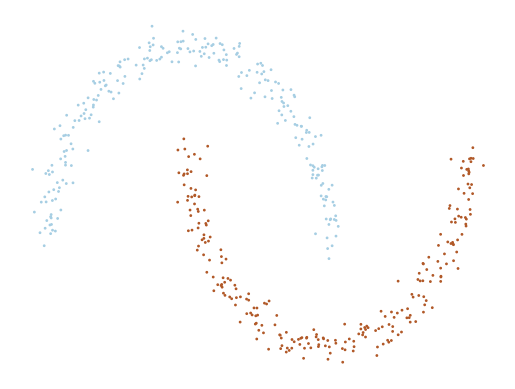

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_noise = 0.05
X, y = make_moons(n_samples=500, noise=data_noise,)

plt.scatter(X[:, 0], X[:, 1], c=y, s=1,cmap='Paired') 

plt.axis('off')
plt.show()

Now let's implement the interpolant to generate $x_t$ and check it visually

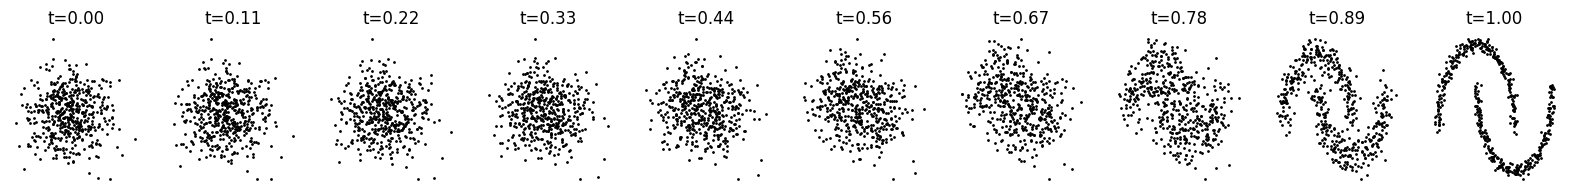

In [ ]:

def interpolant(x0, x1, t):
    """
    #TODO:

    Implement the linear interpolation between noise (x0) and data (x1).
    
    At t=0: we should get pure noise (x0)
    At t=1: we should get real data (x1) 
    At t=0.5: we should get a 50/50 mix
    
    Args:
        x0: Starting point (noise), shape: (batch_size, ...)
        x1: End point (data), shape: (batch_size, ...)
        t: Time parameter, shape: (batch_size,) or scalar
        
    Returns:
        x_t: Interpolated samples at time t
    """
    # Your code here
    return (1 - t) * x0 + t * x1

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

x1, _ = make_moons(n_samples=500, noise=data_noise,)
x1 = torch.tensor(x1).float()
x0  = torch.randn_like(x1)
t = torch.tensor(np.linspace(0., 1., 10))
for i, ax in enumerate(axs):
    xt = interpolant(x0,x1,t[i])
    ax.scatter(xt[:,0], xt[:,1],s=1, color='k')
    ax.axis('off')
    ax.set_title(f't={t[i]:.2f}')

1. **Parametrising the velocity with a neural network**:

First, let's think about the input and output dimensionalities of the velocity model, $v_\theta(x_t,t)$:
- $x_t$ has the same dimensions as $x_1$, in this case: 2d
- $t$ is a scalar
- $v_\theta(x_t,t)$ returns the velocity for each dimension, so also 2d

Let's write a neural network that can do this. One of the advantages of the flow matching formulation is that we can use any neural network architecture as a velocity model. For the two moon problem we will implement a simple MLP, but in the next section we will replace it with a U-Net to generate images.



In [ ]:
import torch.nn as nn

class VelocityNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # TODO: Create a neural network that takes as input:
        # - 2D position (x_t): 2 dimensions  
        # - 1D time (t): 1 dimension
        # Total input: 3 dimensions
        # 
        # Output: 2D velocity vector
        #
        # Store this in self.net as a nn.Sequential
        
        #self.net = # Your code here
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),  # 2D position + 1D time
            nn.SiLU(),  # Smooth activation function
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 2)  # Output 2D velocity
        )

    def forward(self, xt, t):
        # TODO: Combine xt and t into a single input tensor and pass it through the 
        # velocity prediction network
        if t.dim() == 1:
            t = t.unsqueeze(1)
        xt = torch.cat([xt, t], dim=1)
        v = self.net(xt)
        return v



In [9]:
velocity_nn = VelocityNetwork(
    hidden_dim=256,
).to(device)
t=torch.tensor(500*[0.5],dtype=torch.float32, device=device)

assert velocity_nn(
    xt=x1.to(device),
    t=t,
).shape == (500, 2), "Expected shape (500, 2) but got different shape"

2. **Write down the flow matching model**:

Computing the loss is simple:

1. **Sample a random training pair**: Pick noise $x_0$ and real data $x_1$
2. **Pick a random time**: Choose $t$ uniformly between 0 and 1 to Monte Carlo estimate the expectation value over time.
3. **Get the interpolated data**: $x_t = (1-t)x_0 + tx_1$
4. **Evaluate the velocity prediction network**: "What velocity do you predict at $(x_t, t)$?"
5. **Compare with truth when knowing $x_1$**
6. **Update weights**: Use backpropagation to improve predictions


In [ ]:
class FlowMatching:
    def __init__(self, velocity_network, device='cuda'):
        self.velocity_net = velocity_network
        self.device = device
        
    def sample_time(self, batch_size):
        """Sample random time steps between 0 and 1."""
        return torch.rand(batch_size, device=self.device)
    
    def interpolate(self, x0, x1, t):
        """
        Linear interpolation between noise (x0) and data (x1).
        At t=0: return x0 (noise)
        At t=1: return x1 (data)
        """
        # TODO: fill in the interpolant again
        t_shape = [t.size(0)] + [1] * (x1.dim() - 1)
        t = t.view(t_shape)
        return (1 - t) * x0 + t * x1
    
    def compute_target_velocity(self, x0, x1, t):
        """
        #TODO
        Compute the target velocity field that the neural network should learn.
        
        Think about this: if we have x_t = (1-t)*x0 + t*x1, 
        what is dx_t/dt (the derivative with respect to time)?
        """
        # Your code here
        #return # What is dx_t/dt?
        return x1 - x0
    
    def compute_loss(self, x1,):
        """
        Compute flow matching loss.
        
        Args:
            x1: data samples
        
        Returns:
            Loss value
        """
        # TODO: compute the flow matching loss given the functions above
        x0 = torch.randn_like(x1)
        t = self.sample_time(len(x1))
        
        xt = self.interpolate(x0, x1, t)
        
        target_velocity = self.compute_target_velocity(x0, x1, t)
        
        predicted_velocity = self.velocity_net(xt, t)
        
        loss = nn.MSELoss()(predicted_velocity, target_velocity)
        return loss
    
    def sample(self, target_shape=(2,), num_samples=10, num_steps=100,):
        """
        Generate samples by integrating the learned velocity field.
        
        Args:
            num_samples: Number of samples to generate
            num_steps: Number of integration steps
        
        Returns:
            Generated samples
        """
        self.velocity_net.eval()
        # TODO: Solve the ODE via Euler integration

        dt = 1.0 / num_steps
        x0 = torch.randn(num_samples, *target_shape, device=self.device)
        x = x0
        with torch.no_grad():
            # Integrate the velocity field from t=0 to t=1
            for i in range(num_steps):
                t = torch.full((num_samples,), i * dt, device=self.device)
                velocity = self.velocity_net(x, t )
                # Euler integration step
                x = x + velocity * dt
        return x

In [11]:
fm = FlowMatching(
    velocity_network=velocity_nn,
    device=device,
)


First, let's check that we can call compute_loss. If our data is standarized, we should expect a randomly initialized velocity network to return something of the order of 1. Always pay attention to the initial values of the loss funciton, as huge or tiny values usually indicate bugs.

In [12]:
fm.compute_loss(
    x1=x1.to(device),
)

tensor(1.5647, grad_fn=<MseLossBackward0>)

Now let's check the ODE solver code to generate new samples

In [14]:
samples = fm.sample(
   num_samples=500,

).cpu().numpy()

assert samples.shape == (500, 2), "Expected shape (500, 2) but got different shape"

If we plot them, they should look completely random given that the velocity network hasn't been trained yet

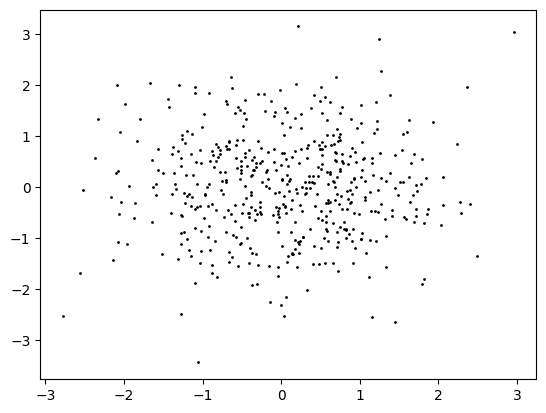

In [16]:
plt.scatter(
    samples[:,0],
    samples[:,1],
    c='k',
    s=1,
)

Now let's write the training loop to improve our currently very useless velocity model :)

In [17]:
from tqdm import tqdm
import torch.optim as optim
from IPython.display import clear_output

In [19]:
def train_step(flow_matching, optimizer, batch, device):
    """
    Perform a single training step.
    
    Args:
        flow_matching: FlowMatching instance
        optimizer: Optimizer
        batch: (x, y) batch
        device: Device to use
    
    Returns:
        loss: Training loss for this step
    """
    x, y = batch
    x = torch.tensor(x,).float()
    x = x.to(device)
    # Forward pass
    optimizer.zero_grad()
    loss = flow_matching.compute_loss(x)

    # Backward pass
    loss.backward()
    optimizer.step()
    return loss.item()


def train_flow_matching(
    velocity_network,
    device='cuda',
    lr=1e-4,
    batch_size=32,
    total_steps=50000,
    generate_every=2000,
):
    """
    Train a flow matching model 
    
    Args:
        velocity_network: The velocity neural network
        device: Device to train on
        lr: Learning rate
        batch_size: Batch size
        total_steps: Total training steps
        generate_every: Generate sample images every N steps
    
    Returns:
        velocity_network: Trained model
        train_losses: List of training losses
    """
    velocity_network = velocity_network.to(device)
    flow_matching = FlowMatching(velocity_network, device)
    optimizer = optim.AdamW(velocity_network.parameters(), lr=lr, weight_decay=1e-4)
    
    step = 0
    
    train_losses = []
    
    print(f"Starting training for {total_steps} steps...")
    print(f"Device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in velocity_network.parameters()):,}")
    
    with tqdm(total=total_steps, desc="Training") as pbar:
        while step < total_steps:
            batch = make_moons(n_samples=batch_size, noise=data_noise,)
            
            loss = train_step(flow_matching, optimizer, batch, device)
            train_losses.append(loss)
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss:.4f}',
            })
            pbar.update(1)
            step += 1

            
            # Plot samples form the model after generate_every steps
            if step % generate_every == 0:
                print(f"\nGenerating samples at step {step}...")
                
                samples = flow_matching.sample(
                    num_samples=500, 
                    num_steps=100,
                )
                
                clear_output(wait=True)
                plt.scatter(
                    batch[0][:,0],
                    batch[0][:,1],
                    c='indianred',
                    s=1,
                    alpha=0.8,
                    label='Original'
                )
                plt.scatter(
                    samples[:,0].cpu().numpy(),
                    samples[:,1].cpu().numpy(),
                    c='k',
                    s=1,
                    label='Generated'
                )
                plt.legend()
                plt.title(f'Generated Samples at step {step}')
                plt.axis('off')
                plt.show()

    
    print("\nTraining completed!")
   
    return velocity_network, train_losses 

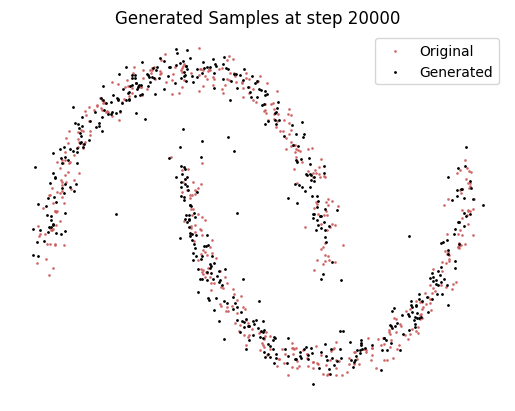

Training: 100%|██████████| 20000/20000 [01:33<00:00, 212.90it/s, Loss=0.8946]


Training completed!


In [21]:

velocity_network, train_losses = train_flow_matching(
    velocity_nn,
    device='cpu',
    lr=5e-4,
    batch_size=512,
    total_steps=20_000,
    generate_every=1_000,
)


Text(0, 0.5, 'Training loss')

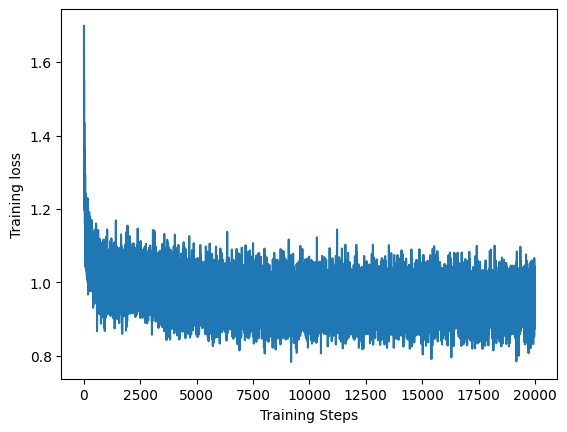

In [22]:
plt.plot(train_losses)
plt.xlabel('Training Steps')
plt.ylabel('Training loss')

#TODO: Conditional Flow Matching
Currently our model generates unconditional samples. Let's make it conditional!

1. Modify the VelocityNetwork to accept class labels:
   - Add class embedding layer: nn.Embedding(num_classes, embedding_dim)
   - Concatenate class embedding with position and time
   - New input size: 2 (position) + 1 (time) + embedding_dim

2. For the two moons dataset, you can use the labels (y) from make_moons to condition on which "moon" to generate

3. Modify the compute_loss function to:
   - Sample class labels during training
   - Pass labels to the velocity network

4. Modify the sample function to:
   - Accept a target class as input
   - Generate samples from that specific class

Try implementing this and see if you can generate samples from each moon separately!

Some additional extra #TODOs are to
- Create an animation of the generation process showing how noise gradually transforms into data over the integration steps

- Plot the learned velocity field. Create a grid of points and visualize the velocity vectors at different times. This helps understand how the model "flows" from noise to data

# Galaxy Images

In [ ]:
import torchvision
import PIL
import glob
from pathlib import Path



In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1QjTECPvkzrXUJxishXS-0KTknNq0erly

In [ ]:
!unzip -q gz_data.zip

In [ ]:


fig, ax = plt.subplots(ncols=2)
for s, a in zip(['elliptical', 'spiral'], ax) :
  a.imshow(PIL.Image.open(glob.glob(f'/curated_data/{s}/*.jpg')[0]))
  a.set_title(s)
  a.axis('off')

In [ ]:
data_mean, data_std = 0.03736, 0.0714 # Used to standarize the data
rng = torch.Generator().manual_seed(137)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x - data_mean)/ data_std),
])
dataset = torchvision.datasets.ImageFolder('curated_data', transform=transform)

len_train = int(0.7*len(dataset))
len_valid = int(0.2*len(dataset))
len_test = len(dataset) - len_train - len_valid
trainset, validset, testset = torch.utils.data.random_split(
    dataset,
     [len_train, len_valid, len_test],
    generator=rng
)

In [ ]:
print(f'Data set sizes:\n\ttraining:\t{len(trainset)}\n\tvalidation:\t{len(validset)}\n\ttesting:\t{len(testset)}')

In [ ]:


fig, axs = plt.subplots(1, 10, figsize=(20, 2))
x1, _ = trainset[1]
x0  = torch.randn_like(x1)
t = torch.tensor(np.linspace(0., 1., 10))
for i, ax in enumerate(axs):
    xt = interpolant(x0,x1,t[i])
    xt = np.transpose(xt.numpy(), (1, 2, 0))
    xt_norm = (xt - xt.min()) / (xt.max() - xt.min())  # Normalize to [0, 1]
    ax.imshow(xt_norm) 
    ax.axis('off')
    ax.set_title(f't={t[i]:.2f}')


Given the flexibility of flow matching, we can use all the previously developed code to generate images too, as long as the velocity network works for images. Let's now think about the dimensionality of the velocity model for the galaxy images:
- $x_t$ has the same dimensions as $x_1$, in this case: (3,424,424)
- $t$ is a scalar
- $v_\theta(x_t,t)$ returns the velocity at each pixel, so also (3,424,424)

State-of-the-art generative models for images are either U-Net based (convolutional) or vision transformers. To start with, we will implement a U-Net.

This is the basic structure of a U-Net, designed to extract features over different scales. In our example, the U-Net input will be $x_t$ and $t$ and its output $v_\theta(x_t,t)$. We will use a 2D Unet implemented in the diffuseres library

![U-Net architecture](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)



In [ ]:
from diffusers import UNet2DModel

class VelocityNetwork(nn.Module):
    def __init__(self, device,):
        super().__init__()
        self.unet = UNet2DModel(
            sample_size=434,        
            in_channels=3, 
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(32, 32, 64, 128),  
            down_block_types= tuple(['DownBlock2D'] * 4),
            up_block_types= tuple(['UpBlock2D'] * 4),
        ).to(device)

    def forward(self, xt, t):
        return self.unet(xt, t).sample

In [ ]:
velocity_nn = VelocityNetwork(device=device)

assert velocity_nn(
    x1[None].to(device),
    torch.tensor([0.5], device=device),
).shape == (1, 3, 424, 424)

In [ ]:
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from tqdm import tqdm
import torch.optim as optim
from IPython.display import clear_output


In [ ]:
# This function will help us plot samples during training
def plot_images_inline(images, title="Generated Images", nrow=4, figsize=(10, 6)):
    """Plot images inline in notebook."""
   
    grid = vutils.make_grid(images, nrow=nrow, padding=10, pad_value=1.)
    
    grid = grid.cpu().numpy().transpose(1, 2, 0)
    grid = (grid - grid.min()) / (grid.max() - grid.min()) 

    plt.figure(figsize=figsize)
    plt.imshow(grid)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:


def train_flow_matching(
    velocity_network,
    trainset,
    device='cuda',
    lr=1e-4,
    batch_size=32,
    total_steps=50000,
    generate_every=2000,
):
    """
    Train a flow matching model with inline plotting.
    
    Args:
        velocity_network: The velocity neural network
        trainset: Training dataset
        device: Device to train on
        lr: Learning rate
        batch_size: Batch size
        total_steps: Total training steps
        generate_every: Generate sample images every N steps
    
    Returns:
        velocity_network: Trained model
        train_losses: List of training losses
    """
    
    # Setup data loaders
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    # Initialize flow matching and move to device
    velocity_network = velocity_network.to(device)
    flow_matching = FlowMatching(velocity_network, device)
    
    # Setup optimizer and scheduler
    optimizer = optim.AdamW(velocity_network.parameters(), lr=lr, weight_decay=1e-4)
    
    # Training loop
    step = 0
    train_iter = iter(train_loader)
    
    # Lists to track metrics
    train_losses = []
    
    print(f"Starting training for {total_steps} steps...")
    print(f"Device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in velocity_network.parameters()):,}")
    
    with tqdm(total=total_steps, desc="Training") as pbar:
        while step < total_steps:
            try:
                # Get next batch
                batch = next(train_iter)
            except StopIteration:
                # Restart iterator when we reach the end
                train_iter = iter(train_loader)
                batch = next(train_iter)
            
            loss = train_step(flow_matching, optimizer, batch, device)
            train_losses.append(loss)
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss:.4f}',
            })
            pbar.update(1)
            step += 1
            

            if step % generate_every == 0:
                print(f"\nGenerating samples at step {step}...")
                
                samples = flow_matching.sample(
                    num_samples=16, 
                    num_steps=100,
                    target_shape=(3,424,424),
                )
                # Plot samples inline
                clear_output(wait=True)
                plot_images_inline(
                    samples, 
                    title=f"Generated Samples - Step {step}",
                    nrow=4,
                    figsize=(8, 6)
                )
            
    
    print("\nTraining completed!")
   
    return velocity_network, train_losses 


velocity_network, train_losses = train_flow_matching(
    velocity_nn,
    trainset,
    device='cuda',
    lr=1e-4,
    batch_size=8,
    total_steps=50000,
    generate_every=100,
)


## Common Issues and Debugging Tips 

### "My model isn't learning!" 
- ✅ Check that loss is decreasing (even slowly)
- ✅ Verify your interpolant function is correct
- ✅ Make sure target velocity = x1 - x0
- ✅ Try a smaller learning rate

### "Generated samples look like noise!"
- ✅ Train longer (flow matching can be slow to start)
- ✅ Increase model capacity 
- ✅ Check your sampling function (are you starting from noise?)

### "Training is too slow!"
- ✅ Reduce batch size if GPU memory is full
- ✅ Use mixed precision training (torch.cuda.amp)
- ✅ Start with fewer integration steps, increase later

### "Galaxy images are blurry!"
- ✅ This is normal early in training
- ✅ Try training longer
- ✅ Consider using a larger U-Net
- ✅ Check if your data normalization is correct
- ✅ Check the data sampling is working correctly

## Validating Our Galaxy Generator: Beyond "Looks Good" 

Visual inspection is important, but we need quantitative metrics too. Here are some of the metrics one can use to quantitatively evaluate the generative model: 

##### 1. **Statistical Consistency** 
Do our generated galaxies have the same statistical properties as real ones?
- **Pixel intensity distributions**: Histograms should match
- **Brightness statistics**: Mean, variance, skewness
- Any other summary statistics that matter for our problem

##### 2. **The Discriminator Test** 
Train a classifier to distinguish real vs. generated galaxies:
- **Seems to work**: Classifier accuracy ≈ 50% (random guessing)
- **Reality check**: If accuracy >> 50%, our generator needs work
- **Caveat**: Bad classifier ≠ good generator (classifier might be too simple). It's a necessary test but not sufficient

##### 3. **Conditional Generation Validation** 
If we condition on galaxy type (spiral vs. elliptical):
- Train a separate classifier to predict galaxy type from images
- Generated spirals should be classified as spirals (and vice versa)
- Measures if our conditioning actually works

##### 4. **Coverage and Mode Collapse** 
- **Coverage**: Do we generate the full diversity of real galaxies?
- **Mode collapse**: Are we just memorizing a few training examples?

Always use multiple metrics! No single number tells the full story.